In [ ]:
running_on_kaggle = True

if running_on_kaggle:
    # Kaggle does not automatically have this
    !pip install torch_geometric -q

In [2]:
import os
import sys
from tqdm import tqdm
from datetime import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch

In [3]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

if running_on_kaggle:
    train_file = np.load("/kaggle/input/cse-251-b-2025/train.npz")
    test_file = np.load("/kaggle/input/cse-251-b-2025/test_input.npz")
else:
    train_file = np.load("./cse-251-b-2025/train.npz")
    test_file = np.load("./cse-251-b-2025/test_input.npz")

train_data = train_file['data']
test_data = test_file['data']

print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

In [4]:
# Run visualizations?
run_visualizations: bool = False

# From data loading notebook
def plot_one_training_scene(idx: int = 0):
    # Plot trajectories from one training scene (static plot)
    data_matrix = train_data[idx]

    plt.figure(figsize=(8, 8))
    for agent in range(data_matrix.shape[idx]):
        xs = data_matrix[agent, :, 0]
        ys = data_matrix[agent, :, 1]
        # Remove zeros (padding)
        xs = xs[xs != 0]
        ys = ys[ys != 0]
        plt.plot(xs, ys, alpha=0.7)
    plt.title("Trajectories from one training scene")
    plt.xlabel("x-coordinate")
    plt.ylabel("y-coordinate")
    plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

if run_visualizations:
    plot_one_training_scene(0)
    make_gif(train_data[0], 'index0')

# Constant velocity from test set
Untouched from original data loading notebook.

In [5]:
# Run constant velocity model (Kaggle score of ~50)?
run_constant_velocity_model: bool = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Our Work

In [6]:
# MLP model with residual blocks: ineffective for TimeSeries data
class BasicMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()

        # Lazy layers infer the input size instead of having to explicitly pass it in
        # Backbone: linear -> BatchNorm -> PReLU -> Dropout
        self.net = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.2),
        ) # Note: residual width must match the last width of the net

        # Residual block added to avoid vanishing gradient issue
        self.residual = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(256),
        )

        # Infer last input shape, then do final projection (60*2)
        self.head = nn.LazyLinear(output_features)

    def forward(self, x):
        # Original forward loop
        # # (batch, 50, 50, 6) or flattened already
        # x = x.view(x.size(0), -1)
        # h = self.net(x) #(batch, 256)
        # h = h + self.residual(h)  # residual skip
        # return self.head(h) #(batch, 120)

        # Taken from milestone notebook (tensor format)
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.net(x)
        x = x + self.residual(x)
        x = self.head(x)
        return x.view(-1, 60, 2)

In [7]:
# Base LSTM given to us in the milestone notebook
class BaseLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [8]:
# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):
        # x = data.x
        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        # x = x.reshape(-1, 50 * 50 * 6)
        # x = self.mlp(x)
        # return x.view(-1, 60, 2)
        # In case you passed in a DataBatch
        if not isinstance(x_flat, torch.Tensor):
            x_flat = x_flat.x

        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)

        out = self.decoder(combined) #(B, 120)
        return out.view(-1, 60, 2)

In [9]:
# Extended from the base LSTM model
class LSTMWithMLP(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        x = self.net(lstm_out[:, -1, :])
        x = self.fc(x)
        return x.view(-1, 60, 2)

In [10]:
class LSTMButTwo(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        self.second_out_dim = 128

        self.lstm_1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)

        self.residual = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, self.second_out_dim),
        )
        
        self.lstm_2 = nn.LSTM(hidden_dim, self.second_out_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(self.second_out_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_first_out, _ = self.lstm_1(x)
        residual = self.residual(lstm_first_out)
        lstm_second_out, _ = self.lstm_2(lstm_first_out)
        lstm_plus_res = lstm_second_out + residual

        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        lstm_out = lstm_plus_res[:, -1, :]
        x = self.fc(lstm_out)
        return x.view(-1, 60, 2)

In [11]:
# Coded with assistance from ChatGPT 4o to understand the attention mechanism stated in
# the paper "Time Series Prediction Based on LSTM-Attention-LSTM Model" along with noting
# the dimensions after each operation. Deepseek was also used to help with dimension issues,
# such as when to squeeze/unsqueeze, especially debugging the decoder LSTM.
class LSTMAttLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        
        # Encoder: encodes input dimensions into hidden
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)

        # Decoder: another LSTM layer that decodes the encoder's hidden state
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)

        # Output
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        # Only consider Ego agent at index 0 -> (batch_size, seq_len, input_dim)
        x = x[:, 0, :, :] # Can adjust how much of the sequence to consider
        # B, L, D = x.shape

        # nn.LSTM: # enc_out: (B, L, H), h_n: (D*num_layers, B, H)
        encoder_out, (h_n, c_n) = self.encoder(x)

        # Last hidden state: (B, H)
        h_n_last = h_n[-1]

        # "Attention correlations"
        # Unsqueeze -> extend a dimension (so the matrix multiplication works)
        # torch.bmm -> matrix multiplication/dot product across batches
        # Squeeze -> contract a dimension (remove the previous phantom dimension)
        # e: (B, L)
        e = torch.bmm(encoder_out, h_n_last.unsqueeze(2)).squeeze(2)

        # Attention weights: (B, L)
        alpha = F.softmax(e, dim=1) # dim=1 to go along seq_len

        # Context vector: (B, H)
        # Unsqueeze alpha to (B, 1, L) to matrixmul into encoder (B, L, H)
        # Squeeze the expanded dimension to reach (B, H)
        context = torch.bmm(alpha.unsqueeze(1), encoder_out).squeeze(1)

        # Decoder: pass in the encoder's last hidden state (h_i)
        # Unsqueeze context to a "one-step" sequence
        context = context.unsqueeze(1)  # (B, 1, H)
        decoder_h0 = h_n[-1].unsqueeze(0)  # (1, B, H)
        decoder_c0 = c_n[-1].unsqueeze(0)  # (1, B, H)
        decoder_out, _ = self.decoder(context, (decoder_h0, decoder_c0))  # (B, 1, H)
        decoder_out = decoder_out.squeeze(1)  # (B, H)

        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)

**Multi-Agent Models**

In [ ]:
# AI (Claude) assistance was used for help with finding different ways to integrate multiple agents

# Multi-Agent LSTM with Agent-Level Attention
class MultiAgentLSTMWithAttention(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1, max_agents=50):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.max_agents = max_agents
        
        # Encoder for each agent's trajectory
        self.agent_encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Agent-level attention mechanism
        self.agent_attention = nn.MultiheadAttention(hidden_dim, num_heads=8, dropout=dropout, batch_first=True)
        
        # Temporal LSTM decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Output projection
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        # Reshape to (batch_size, num_agents, seq_len, input_dim)
        x = x.reshape(-1, 50, 50, 6)
        batch_size, num_agents, seq_len, input_dim = x.shape
        
        # Process each agent's trajectory
        # Reshape to process all agents at once: (batch_size * num_agents, seq_len, input_dim)
        x_flat = x.reshape(-1, seq_len, input_dim)
        
        # Encode each agent's trajectory
        agent_encoded, (h_n, c_n) = self.agent_encoder(x_flat)
        
        # Get final hidden state for each agent: (batch_size * num_agents, hidden_dim)
        agent_features = h_n[-1]  # Last layer's hidden state
        
        # Reshape back to separate agents: (batch_size, num_agents, hidden_dim)
        agent_features = agent_features.reshape(batch_size, num_agents, self.hidden_dim)
        
        # Apply agent-level attention (ego agent attends to all agents)
        ego_query = agent_features[:, 0:1, :]  # Ego agent as query
        attended_features, attention_weights = self.agent_attention(
            ego_query, agent_features, agent_features
        )
        
        # Decode the attended features
        context = attended_features  # (batch_size, 1, hidden_dim)
        decoder_out, _ = self.decoder(context)
        decoder_out = decoder_out.squeeze(1)  # (batch_size, hidden_dim)
        
        # Final prediction
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)


# Hierarchical Multi-Agent LSTM
class HierarchicalMultiAgentLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Individual agent trajectory encoder
        self.agent_lstm = nn.LSTM(input_dim, hidden_dim//2, batch_first=True, dropout=dropout)
        
        # Scene-level LSTM to process all agents
        self.scene_lstm = nn.LSTM(hidden_dim//2, hidden_dim, batch_first=True, dropout=dropout)
        
        # Decoder LSTM
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        # Reshape to (batch_size, num_agents, seq_len, input_dim)
        x = x.reshape(-1, 50, 50, 6)
        batch_size, num_agents, seq_len, input_dim = x.shape
        
        # Encode each agent's trajectory
        x_flat = x.reshape(-1, seq_len, input_dim)
        agent_encoded, (h_n, _) = self.agent_lstm(x_flat)
        
        # Get final hidden state for each agent
        agent_features = h_n[-1].reshape(batch_size, num_agents, -1)
        
        # Process agent interactions at scene level
        scene_encoded, (scene_h, scene_c) = self.scene_lstm(agent_features)
        
        # Focus on ego agent's representation after scene processing
        ego_context = scene_encoded[:, 0:1, :]  # (batch_size, 1, hidden_dim)
        
        # Decode future trajectory
        decoder_out, _ = self.decoder(ego_context, (scene_h, scene_c))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)


# Graph-inspired Multi-Agent LSTM (using agent proximity)
class GraphMultiAgentLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Agent trajectory encoders
        self.agent_encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Graph convolution-like layer for agent interactions
        self.agent_interaction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Attention for selecting relevant agents
        self.relevance_attention = nn.Linear(hidden_dim, 1)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        x = x.reshape(-1, 50, 50, 6)
        batch_size, num_agents, seq_len, input_dim = x.shape
        
        # Encode all agents
        x_flat = x.reshape(-1, seq_len, input_dim)
        encoded, (h_n, c_n) = self.agent_encoder(x_flat)
        
        # Agent features: (batch_size, num_agents, hidden_dim)
        agent_features = h_n[-1].reshape(batch_size, num_agents, self.hidden_dim)
        
        # Calculate agent relevance (simple distance-based or learned)
        relevance_scores = self.relevance_attention(agent_features)  # (batch_size, num_agents, 1)
        relevance_weights = F.softmax(relevance_scores.squeeze(-1), dim=1)  # (batch_size, num_agents)
        
        # Agent interaction processing
        interacted_features = self.agent_interaction(agent_features)
        
        # Weighted combination of agent features
        ego_context = torch.sum(interacted_features * relevance_weights.unsqueeze(-1), dim=1, keepdim=True)
        
        # Decode
        decoder_out, _ = self.decoder(ego_context)
        decoder_out = decoder_out.squeeze(1)
        
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)


# Simple Multi-Agent Concatenation LSTM
class ConcatMultiAgentLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1, num_agents_to_use=10):
        super().__init__()
        self.num_agents_to_use = num_agents_to_use
        
        # Encoder for multiple agents (concatenated features)
        self.encoder = nn.LSTM(input_dim * num_agents_to_use, hidden_dim, batch_first=True, dropout=dropout)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, dropout=dropout, batch_first=True)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        x = x.reshape(-1, 50, 50, 6)
        
        # Take first N agents and concatenate their features
        x_selected = x[:, :self.num_agents_to_use, :, :]  # (batch, N_agents, seq_len, 6)
        
        # Concatenate agent features: (batch, seq_len, N_agents * 6)
        x_concat = x_selected.permute(0, 2, 1, 3).reshape(x.size(0), 50, -1)
        
        # Encode concatenated features
        encoded, (h_n, c_n) = self.encoder(x_concat)
        
        # Self-attention on encoded sequence
        attended, _ = self.attention(encoded, encoded, encoded)
        
        # Use last timestep for decoding
        context = attended[:, -1:, :]  # (batch, 1, hidden_dim)
        
        decoder_out, _ = self.decoder(context, (h_n, c_n))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)
    
# Gradual Multi-Agent Integration
class SimpleMultiAgentLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1, num_agents=5):
        super().__init__()
        self.num_agents = num_agents
        
        # Single LSTM that processes multiple agents sequentially
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Simple attention mechanism (simpler than MultiheadAttention)
        self.attention_fc = nn.Linear(hidden_dim, 1)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Output layers (same as original)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        x = x.reshape(-1, 50, 50, 6)
        batch_size = x.size(0)
        
        # Only use first N agents (including ego at index 0)
        x_selected = x[:, :self.num_agents, :, :]  # (batch, N_agents, seq_len, 6)
        
        # Process each agent and collect their final hidden states
        agent_features = []
        for i in range(self.num_agents):
            agent_traj = x_selected[:, i, :, :]  # (batch, seq_len, 6)
            _, (h_n, c_n) = self.encoder(agent_traj)
            agent_features.append(h_n[-1])  # (batch, hidden_dim)
        
        # Stack agent features: (batch, num_agents, hidden_dim)
        agent_features = torch.stack(agent_features, dim=1)
        
        # Simple attention weights
        attention_scores = self.attention_fc(agent_features).squeeze(-1)  # (batch, num_agents)
        attention_weights = F.softmax(attention_scores, dim=1)
        
        # Weighted combination
        context = torch.sum(agent_features * attention_weights.unsqueeze(-1), dim=1, keepdim=True)
        
        # Decode
        decoder_out, _ = self.decoder(context)
        decoder_out = decoder_out.squeeze(1)
        
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)


# Simplest: just average multiple agents
class AverageMultiAgentLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1, num_agents=3):
        super().__init__()
        self.num_agents = num_agents
        
        # Same architecture as original LSTMAttLSTM
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        x = x.reshape(-1, 50, 50, 6)
        
        # Average the trajectories of first N agents
        x_avg = x[:, :self.num_agents, :, :].mean(dim=1)  # (batch, seq_len, 6)
        
        # Same logic as your original LSTMAttLSTM
        encoder_out, (h_n, c_n) = self.encoder(x_avg)
        h_n_last = h_n[-1]
        
        # Attention
        e = torch.bmm(encoder_out, h_n_last.unsqueeze(2)).squeeze(2)
        alpha = F.softmax(e, dim=1)
        context = torch.bmm(alpha.unsqueeze(1), encoder_out).squeeze(1)
        
        # Decode
        context = context.unsqueeze(1)
        decoder_h0 = h_n[-1].unsqueeze(0)
        decoder_c0 = c_n[-1].unsqueeze(0)
        decoder_out, _ = self.decoder(context, (decoder_h0, decoder_c0))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)

# Preparing data

`TrajectoryDataset*` are taken from the milestone notebook.

In [13]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R gives DeprecationWarning: future a torch.Tensor
                future = torch.from_numpy(np.dot(future.numpy(), R)) 
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin -> same DeprecationWarning
        future = torch.from_numpy(future.numpy() - origin)

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [14]:
# Taken from milestone notebook
# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using Apple Silicon GPU


In [15]:
# Functions to save and load the model (should correspond to what was trained!)
def save_model(model, path="our_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(model_instance, path="our_model.pth"):
    loaded_model = model_instance
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model


# Example usage:
# save_model(trained_model)
# model = load_model()

In [16]:
def get_timestamp() -> str:
    return datetime.now().strftime("%Y-%m-%d_%I-%M%p")

In [17]:
# Set up hyperparameters

# Calculate number of input features after flattening and number of output features
# Note: LSTM models take features in different dimensions
input_features:int = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each (15000 input features)
output_features:int = 60 * 2       # 60 future time steps, 2 dimensions (x, y) (120 output features)

# Hyperparameters
batch_size: int = 32
num_folds: int = 3
early_stopping_patience: int = 30
early_stopping_threshold: float = 1e-5
epochs: int = 300
starting_lr: float = 1e-2
scale: float = 10.0
weight_decay: float = 1e-2
gradient_norm_clip = 2.0

lstm_hidden_dim: int = 64 # 128


SEED: int = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
# IMPORTANT! To change which model is used: comment/uncomment below
# Easily swap models by changing what is returned (called in training and test to avoid conflicts)
def get_model():
    global lstm_hidden_dim, input_features, output_features

    # return BasicMLP(input_features, output_features).to(device)
    # return BaseLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return SceneContextModel(hidden_dim=864).to(device)
    # return LSTMWithMLP(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return LSTMButTwo(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return LSTMAttLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)

    # return MultiAgentLSTMWithAttention(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)            # terrible - 200s
    # return HierarchicalMultiAgentLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)             # potential
    # return GraphMultiAgentLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)                    # potential
    # return ConcatMultiAgentLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features, num_agents_to_use=3).to(device)  # maybe
    return SimpleMultiAgentLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features, num_agents=5).to(device)       # Best so far
    # return AverageMultiAgentLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features, num_agents=2).to(device)    # terrible

In [33]:
def train_model(full_training_data: np.ndarray, 
                batch_size:int = 64, epochs:int = 10, num_folds:int = 5,
                early_stopping_patience:int = 5, early_stopping_threshold:float = 1e-3):
    global starting_lr, gamma, scale, lstm_hidden_dim, output_features, weight_decay, gradient_norm_clip

    # Time series data needs to keep its data in relative order, so no shuffling can occur
    #   like in regular KFold cross validation
    splitter = TimeSeriesSplit(n_splits=num_folds, test_size=int(0.20 * len(full_training_data)))

    # Perform cross-validation, the best model will be saved as "best_model.pt" to be loaded in later
    overall_best_val_loss = float("inf")
    overall_best_seen_at = (0, 0) #(epoch, fold)

    # Resources used:
    # Project milestone notebook
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    # https://www.geeksforgeeks.org/time-series-cross-validation/
    for fold_i, (train_idx, val_idx) in enumerate(splitter.split(full_training_data)):
        print(f"\nFOLD {fold_i + 1}/{num_folds} ==================================")

        # Create the model, loss criterion, and optimizer (reset per fold, to find the best model)
        # If you change the model here, ensure its the same in the test loop!
        # DO NOT CHANGE CRITERION
        criterion = nn.MSELoss()

        model = get_model()
        optimizer = optim.AdamW(model.parameters(), lr=starting_lr, weight_decay=weight_decay)
        schedulers: list[lr_scheduler.LRScheduler] =[
            # lr_scheduler.ExponentialLR(optimizer, gamma=0.995),
            # lr_scheduler.MultiStepLR(
            #     optimizer,
            #     milestones= list(range(25, epochs, 25)),
            #     gamma=0.80,
            # ),
            # lr_scheduler.CosineAnnealingLR(
            #     optimizer, 
            #     T_max= int(epochs * 0.25),
            #     # T_0 = 50,
            #     # T_mult = 2,
            #     eta_min=1e-5
            # ),
            lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min", # reduce LR when there is a plataeu of loss
                factor=0.85,
                patience=5,
                min_lr=1e-5
            )
        ]

        # Prepare data from this fold
        train_fold: np.ndarray = full_training_data[train_idx]
        val_fold: np.ndarray = full_training_data[val_idx]
        collate_func = None     # Optional for DataLoader, taken from milestone notebook
        if not isinstance(model, SceneContextModel):
            # LSTM can handle the timeseries data directly
            # TrajectoryDataset expects numpy arrays
            collate_func = lambda x: Batch.from_data_list(x)
            train_dataset = TrajectoryDatasetTrain(train_fold, scale=scale, augment=True)
            val_dataset = TrajectoryDatasetTrain(val_fold, scale=scale, augment=False)
        else:
            train_x: np.ndarray = train_fold[..., :50, :]
            train_y: np.ndarray = train_fold[:, 0, 50:, :2]
            X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
            y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

            val_x: np.ndarray = val_fold[..., :50, :]
            val_y: np.ndarray = val_fold[:, 0, 50:, :2]
            X_val_tensor = torch.FloatTensor(val_x).reshape((-1, input_features))
            y_val_tensor = torch.FloatTensor(val_y).reshape((-1, output_features))
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

        best_val_loss: float = float("inf")
        no_improvement: int = 0

        # Training and validation loops are taken from the milestone notebook,
        #   with modifications to allow for different data loading shapes      
        for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
            # Training loop
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                    batch_y = batch_y.view(-1, 60, 2)
                else: # DataBatch type
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_norm_clip)
                optimizer.step()
                train_loss += loss.item()

            # Validation loop
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch_x = None
                    batch_y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        batch_x, batch_y = batch
                        batch_y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        batch = batch.to(device)
                        batch_x = batch.x
                        batch_y = batch.y.view(batch.num_graphs, 60, 2)

                    pred = model(batch_x)
                    val_loss += criterion(pred, batch_y).item()

                    # show MAE and MSE with unnormalized data
                    y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                        y = batch_y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    val_mae += nn.L1Loss()(pred, y).item()
                    val_mse += nn.MSELoss()(pred, y).item()

            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)

            if (epoch + 1) % 5 == 0:
                tqdm.write(f"Epoch {(epoch + 1):03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")

            if val_loss < best_val_loss - early_stopping_threshold:
                best_val_loss = val_loss
                no_improvement = 0

                # Better than the overall seen so far?
                if best_val_loss < overall_best_val_loss:
                    overall_best_val_loss = best_val_loss
                    overall_best_seen_at = (epoch + 1, fold_i + 1)
                    torch.save(model.state_dict(), "best_model.pt")
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print(f"==== EARLY STOP at epoch {(epoch + 1):03d}")
                    break

            for sched in schedulers:
                if isinstance(sched, lr_scheduler.ReduceLROnPlateau):
                    sched.step(val_loss)
                else:
                    sched.step()

        # Clean up after the fold finishes to prevent slower folds later
        # https://discuss.pytorch.org/t/how-to-delete-a-tensor-in-gpu-to-free-up-memory/48879
        torch.cuda.empty_cache()
        del train_dataloader, train_dataset, val_dataloader, val_dataset, model, optimizer, schedulers

    print(f"BEST VALIDATION LOSS (NORMALIZED MSE) SEEN: {overall_best_val_loss}, AT (epoch, fold) = {overall_best_seen_at}")

In [34]:
# Load in the model saved during testing to use on X_test
# Mostly taken from milestone notebook
def predict(X_test: np.ndarray, best_model_path: str = "best_model.pt"):
    global scale, batch_size, lstm_hidden_dim, output_features

    # Ensure this aligns with the trained model!
    best_model = torch.load(best_model_path)
    model = get_model()
    model.load_state_dict(best_model)
    model.eval()

    pred_list = []
    with torch.no_grad():
        if not isinstance(model, SceneContextModel): # Using DataBatch type from a DataLoader
            collate_func = lambda x: Batch.from_data_list(x)
            test_dataset = TrajectoryDatasetTest(X_test, scale=scale)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

            for batch in test_loader:
                batch = batch.to(device)
                pred_norm = model(batch.x)

                # Reshape the prediction to (N, 60, 2)
                pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
                pred_list.append(pred.cpu().numpy())
        else:
            X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
            pred = model(X_test_tensor).cpu().reshape((-1, 60, 2))
            pred_list.append(pred.numpy())

    # Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
    pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
    pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
    output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
    output_df.index.name = 'index'
    return output_df

In [ ]:
# Train the model (tweak batch_size and epochs as needed at top of this block)
# Saved as "best_model.pt" to be loaded in during testing
train_model(train_data, batch_size=batch_size, epochs=epochs, num_folds=num_folds,
            early_stopping_patience=early_stopping_patience,
            early_stopping_threshold=early_stopping_threshold)


FOLD 1/3 ==================================


Epoch:   2%|▏         | 5/300 [00:23<22:51,  4.65s/epoch]

Epoch 005 | Learning rate 0.010000 | train normalized MSE   0.2239 | val normalized MSE   0.2493, | val MAE   2.9295 | val MSE  24.9254


Epoch:   3%|▎         | 10/300 [00:45<21:45,  4.50s/epoch]

Epoch 010 | Learning rate 0.010000 | train normalized MSE   0.2086 | val normalized MSE   0.2378, | val MAE   3.0749 | val MSE  23.7777


Epoch:   5%|▌         | 15/300 [01:08<21:19,  4.49s/epoch]

Epoch 015 | Learning rate 0.010000 | train normalized MSE   0.1818 | val normalized MSE   0.2064, | val MAE   2.6056 | val MSE  20.6378


Epoch:   7%|▋         | 20/300 [01:31<21:36,  4.63s/epoch]

Epoch 020 | Learning rate 0.010000 | train normalized MSE   0.1742 | val normalized MSE   0.1591, | val MAE   2.1326 | val MSE  15.9120


Epoch:   8%|▊         | 25/300 [01:54<20:42,  4.52s/epoch]

Epoch 025 | Learning rate 0.010000 | train normalized MSE   0.1595 | val normalized MSE   0.1841, | val MAE   2.2526 | val MSE  18.4128


Epoch:  10%|█         | 30/300 [02:16<20:13,  4.49s/epoch]

Epoch 030 | Learning rate 0.010000 | train normalized MSE   0.1426 | val normalized MSE   0.1430, | val MAE   1.9901 | val MSE  14.2966


Epoch:  12%|█▏        | 35/300 [02:39<19:57,  4.52s/epoch]

Epoch 035 | Learning rate 0.008500 | train normalized MSE   0.1344 | val normalized MSE   0.1367, | val MAE   2.0009 | val MSE  13.6736


Epoch:  13%|█▎        | 40/300 [03:01<19:36,  4.53s/epoch]

Epoch 040 | Learning rate 0.008500 | train normalized MSE   0.1360 | val normalized MSE   0.1343, | val MAE   2.0220 | val MSE  13.4282


Epoch:  15%|█▌        | 45/300 [03:24<19:08,  4.50s/epoch]

Epoch 045 | Learning rate 0.007225 | train normalized MSE   0.1246 | val normalized MSE   0.1218, | val MAE   1.9573 | val MSE  12.1777


Epoch:  17%|█▋        | 50/300 [03:46<18:45,  4.50s/epoch]

Epoch 050 | Learning rate 0.007225 | train normalized MSE   0.1204 | val normalized MSE   0.1226, | val MAE   2.0298 | val MSE  12.2597


Epoch:  18%|█▊        | 55/300 [04:08<18:13,  4.46s/epoch]

Epoch 055 | Learning rate 0.007225 | train normalized MSE   0.1193 | val normalized MSE   0.1167, | val MAE   1.8920 | val MSE  11.6665


Epoch:  20%|██        | 60/300 [04:31<17:59,  4.50s/epoch]

Epoch 060 | Learning rate 0.007225 | train normalized MSE   0.1191 | val normalized MSE   0.1361, | val MAE   2.1107 | val MSE  13.6060


Epoch:  22%|██▏       | 65/300 [04:54<17:31,  4.47s/epoch]

Epoch 065 | Learning rate 0.007225 | train normalized MSE   0.1375 | val normalized MSE   0.1561, | val MAE   2.1750 | val MSE  15.6122


Epoch:  23%|██▎       | 70/300 [05:16<17:24,  4.54s/epoch]

Epoch 070 | Learning rate 0.006141 | train normalized MSE   0.1034 | val normalized MSE   0.1111, | val MAE   1.8212 | val MSE  11.1124


Epoch:  25%|██▌       | 75/300 [05:39<16:40,  4.44s/epoch]

Epoch 075 | Learning rate 0.006141 | train normalized MSE   0.1054 | val normalized MSE   0.1083, | val MAE   1.7261 | val MSE  10.8323


Epoch:  27%|██▋       | 80/300 [06:01<16:16,  4.44s/epoch]

Epoch 080 | Learning rate 0.006141 | train normalized MSE   0.1036 | val normalized MSE   0.1187, | val MAE   1.8483 | val MSE  11.8710


Epoch:  28%|██▊       | 85/300 [06:23<15:57,  4.45s/epoch]

Epoch 085 | Learning rate 0.005220 | train normalized MSE   0.0982 | val normalized MSE   0.1193, | val MAE   1.8881 | val MSE  11.9305


Epoch:  30%|███       | 90/300 [06:45<15:46,  4.51s/epoch]

Epoch 090 | Learning rate 0.004437 | train normalized MSE   0.0965 | val normalized MSE   0.1023, | val MAE   1.7264 | val MSE  10.2323


Epoch:  32%|███▏      | 95/300 [07:08<15:31,  4.55s/epoch]

Epoch 095 | Learning rate 0.004437 | train normalized MSE   0.0922 | val normalized MSE   0.1124, | val MAE   1.8324 | val MSE  11.2358


Epoch:  33%|███▎      | 100/300 [07:31<15:06,  4.53s/epoch]

Epoch 100 | Learning rate 0.003771 | train normalized MSE   0.0934 | val normalized MSE   0.1012, | val MAE   1.6341 | val MSE  10.1226


Epoch:  35%|███▌      | 105/300 [07:54<14:46,  4.55s/epoch]

Epoch 105 | Learning rate 0.003771 | train normalized MSE   0.0937 | val normalized MSE   0.1018, | val MAE   1.6232 | val MSE  10.1801


Epoch:  37%|███▋      | 110/300 [08:17<14:33,  4.60s/epoch]

Epoch 110 | Learning rate 0.003206 | train normalized MSE   0.0884 | val normalized MSE   0.1028, | val MAE   1.6986 | val MSE  10.2793


Epoch:  38%|███▊      | 115/300 [08:39<13:58,  4.53s/epoch]

Epoch 115 | Learning rate 0.003206 | train normalized MSE   0.0896 | val normalized MSE   0.0974, | val MAE   1.5587 | val MSE   9.7388


Epoch:  40%|████      | 120/300 [09:02<13:44,  4.58s/epoch]

Epoch 120 | Learning rate 0.003206 | train normalized MSE   0.0887 | val normalized MSE   0.0988, | val MAE   1.6136 | val MSE   9.8759


Epoch:  42%|████▏     | 125/300 [09:25<13:13,  4.53s/epoch]

Epoch 125 | Learning rate 0.002725 | train normalized MSE   0.0857 | val normalized MSE   0.0966, | val MAE   1.5936 | val MSE   9.6596


Epoch:  43%|████▎     | 130/300 [09:47<12:50,  4.53s/epoch]

Epoch 130 | Learning rate 0.002725 | train normalized MSE   0.0832 | val normalized MSE   0.0982, | val MAE   1.5906 | val MSE   9.8236


Epoch:  45%|████▌     | 135/300 [10:10<12:31,  4.55s/epoch]

Epoch 135 | Learning rate 0.002316 | train normalized MSE   0.0845 | val normalized MSE   0.1021, | val MAE   1.7463 | val MSE  10.2095


Epoch:  47%|████▋     | 140/300 [10:33<12:10,  4.56s/epoch]

Epoch 140 | Learning rate 0.002316 | train normalized MSE   0.0813 | val normalized MSE   0.0972, | val MAE   1.5771 | val MSE   9.7208


Epoch:  48%|████▊     | 145/300 [10:56<11:35,  4.49s/epoch]

Epoch 145 | Learning rate 0.002316 | train normalized MSE   0.0820 | val normalized MSE   0.0982, | val MAE   1.6245 | val MSE   9.8154


Epoch:  50%|█████     | 150/300 [11:18<11:09,  4.46s/epoch]

Epoch 150 | Learning rate 0.002316 | train normalized MSE   0.0836 | val normalized MSE   0.0972, | val MAE   1.6479 | val MSE   9.7172


Epoch:  52%|█████▏    | 155/300 [11:40<10:49,  4.48s/epoch]

Epoch 155 | Learning rate 0.001969 | train normalized MSE   0.0825 | val normalized MSE   0.1017, | val MAE   1.6474 | val MSE  10.1697


Epoch:  53%|█████▎    | 160/300 [12:03<10:29,  4.50s/epoch]

Epoch 160 | Learning rate 0.001673 | train normalized MSE   0.0786 | val normalized MSE   0.0978, | val MAE   1.6407 | val MSE   9.7799


Epoch:  55%|█████▌    | 165/300 [13:20<28:10, 12.52s/epoch]

Epoch 165 | Learning rate 0.001422 | train normalized MSE   0.0756 | val normalized MSE   0.0965, | val MAE   1.6349 | val MSE   9.6516


Epoch:  57%|█████▋    | 170/300 [33:09<3:57:05, 109.43s/epoch] 

Epoch 170 | Learning rate 0.001422 | train normalized MSE   0.0762 | val normalized MSE   0.0928, | val MAE   1.5330 | val MSE   9.2776


Epoch:  58%|█████▊    | 175/300 [34:54<1:28:48, 42.63s/epoch] 

Epoch 175 | Learning rate 0.001209 | train normalized MSE   0.0755 | val normalized MSE   0.0925, | val MAE   1.5851 | val MSE   9.2511


Epoch:  60%|██████    | 180/300 [37:03<59:23, 29.69s/epoch]  

Epoch 180 | Learning rate 0.001209 | train normalized MSE   0.0746 | val normalized MSE   0.0927, | val MAE   1.5829 | val MSE   9.2725


Epoch:  62%|██████▏   | 185/300 [40:34<1:09:56, 36.49s/epoch]

Epoch 185 | Learning rate 0.001209 | train normalized MSE   0.0742 | val normalized MSE   0.0933, | val MAE   1.5825 | val MSE   9.3319


Epoch:  63%|██████▎   | 190/300 [1:24:41<9:25:41, 308.56s/epoch] 

Epoch 190 | Learning rate 0.001028 | train normalized MSE   0.0726 | val normalized MSE   0.0921, | val MAE   1.5427 | val MSE   9.2059


Epoch:  65%|██████▌   | 195/300 [1:53:51<5:57:29, 204.28s/epoch] 

Epoch 195 | Learning rate 0.000874 | train normalized MSE   0.0714 | val normalized MSE   0.0921, | val MAE   1.5528 | val MSE   9.2088


Epoch:  67%|██████▋   | 200/300 [2:22:21<9:31:22, 342.82s/epoch] 

Epoch 200 | Learning rate 0.000743 | train normalized MSE   0.0713 | val normalized MSE   0.0938, | val MAE   1.5729 | val MSE   9.3795


Epoch:  68%|██████▊   | 205/300 [2:54:57<9:02:59, 342.94s/epoch] 

Epoch 205 | Learning rate 0.000631 | train normalized MSE   0.0703 | val normalized MSE   0.0927, | val MAE   1.5308 | val MSE   9.2672


Epoch:  69%|██████▉   | 208/300 [2:57:47<1:18:38, 51.28s/epoch] 

==== EARLY STOP at epoch 209

FOLD 2/3 ==================================



Epoch:   2%|▏         | 5/300 [01:04<59:31, 12.11s/epoch]  

Epoch 005 | Learning rate 0.010000 | train normalized MSE   0.2230 | val normalized MSE   0.2296, | val MAE   2.8412 | val MSE  22.9553


Epoch:   3%|▎         | 10/300 [05:43<6:28:41, 80.42s/epoch]

Epoch 010 | Learning rate 0.010000 | train normalized MSE   0.1941 | val normalized MSE   0.2217, | val MAE   2.7921 | val MSE  22.1727


Epoch:   5%|▌         | 15/300 [07:46<2:11:36, 27.71s/epoch]

Epoch 015 | Learning rate 0.010000 | train normalized MSE   0.1717 | val normalized MSE   0.1584, | val MAE   2.2988 | val MSE  15.8388


Epoch:   7%|▋         | 20/300 [16:13<10:59:35, 141.34s/epoch]

Epoch 020 | Learning rate 0.008500 | train normalized MSE   0.1629 | val normalized MSE   0.1721, | val MAE   2.4881 | val MSE  17.2084


Epoch:   8%|▊         | 25/300 [23:11<8:15:39, 108.14s/epoch] 

Epoch 025 | Learning rate 0.008500 | train normalized MSE   0.1599 | val normalized MSE   0.1746, | val MAE   2.5487 | val MSE  17.4635


Epoch:  10%|█         | 30/300 [32:57<5:06:17, 68.07s/epoch]  

Epoch 030 | Learning rate 0.008500 | train normalized MSE   0.1390 | val normalized MSE   0.1430, | val MAE   2.0562 | val MSE  14.2953


Epoch:  12%|█▏        | 35/300 [37:53<3:42:29, 50.38s/epoch]

Epoch 035 | Learning rate 0.007225 | train normalized MSE   0.1265 | val normalized MSE   0.1388, | val MAE   2.1119 | val MSE  13.8769


Epoch:  13%|█▎        | 40/300 [38:25<1:00:10, 13.89s/epoch]

Epoch 040 | Learning rate 0.007225 | train normalized MSE   0.1192 | val normalized MSE   0.1327, | val MAE   2.1627 | val MSE  13.2659


Epoch:  15%|█▌        | 45/300 [50:15<8:16:11, 116.75s/epoch]

Epoch 045 | Learning rate 0.007225 | train normalized MSE   0.1186 | val normalized MSE   0.1152, | val MAE   1.7533 | val MSE  11.5205


Epoch:  17%|█▋        | 50/300 [54:25<5:43:47, 82.51s/epoch] 

Epoch 050 | Learning rate 0.007225 | train normalized MSE   0.1198 | val normalized MSE   0.1476, | val MAE   2.1709 | val MSE  14.7612


Epoch:  18%|█▊        | 55/300 [1:50:04<57:39:42, 847.27s/epoch]

Epoch 055 | Learning rate 0.007225 | train normalized MSE   0.1115 | val normalized MSE   0.1137, | val MAE   1.8350 | val MSE  11.3680


Epoch:  20%|██        | 60/300 [2:07:24<14:40:24, 220.10s/epoch]

Epoch 060 | Learning rate 0.007225 | train normalized MSE   0.1170 | val normalized MSE   0.1193, | val MAE   1.7981 | val MSE  11.9309


Epoch:  22%|██▏       | 65/300 [2:26:29<8:14:45, 126.32s/epoch] 

Epoch 065 | Learning rate 0.006141 | train normalized MSE   0.1065 | val normalized MSE   0.1099, | val MAE   1.7217 | val MSE  10.9868


Epoch:  23%|██▎       | 70/300 [2:27:00<1:41:11, 26.40s/epoch] 

Epoch 070 | Learning rate 0.006141 | train normalized MSE   0.1032 | val normalized MSE   0.1046, | val MAE   1.6871 | val MSE  10.4563


Epoch:  25%|██▌       | 75/300 [2:27:31<35:41,  9.52s/epoch]  

Epoch 075 | Learning rate 0.006141 | train normalized MSE   0.1068 | val normalized MSE   0.1201, | val MAE   1.8852 | val MSE  12.0132


Epoch:  27%|██▋       | 80/300 [2:28:01<24:30,  6.69s/epoch]

Epoch 080 | Learning rate 0.005220 | train normalized MSE   0.1003 | val normalized MSE   0.1081, | val MAE   1.7676 | val MSE  10.8075


Epoch:  28%|██▊       | 85/300 [2:28:32<22:21,  6.24s/epoch]

Epoch 085 | Learning rate 0.004437 | train normalized MSE   0.0981 | val normalized MSE   0.0995, | val MAE   1.5606 | val MSE   9.9466


Epoch:  30%|███       | 90/300 [2:29:03<21:51,  6.24s/epoch]

Epoch 090 | Learning rate 0.004437 | train normalized MSE   0.0988 | val normalized MSE   0.1066, | val MAE   1.7343 | val MSE  10.6607


Epoch:  32%|███▏      | 95/300 [2:29:35<21:13,  6.21s/epoch]

Epoch 095 | Learning rate 0.003771 | train normalized MSE   0.0945 | val normalized MSE   0.0962, | val MAE   1.6348 | val MSE   9.6181


Epoch:  33%|███▎      | 100/300 [2:30:05<20:31,  6.16s/epoch]

Epoch 100 | Learning rate 0.003771 | train normalized MSE   0.0946 | val normalized MSE   0.1038, | val MAE   1.7507 | val MSE  10.3835


Epoch:  35%|███▌      | 105/300 [2:30:36<20:04,  6.18s/epoch]

Epoch 105 | Learning rate 0.003206 | train normalized MSE   0.0926 | val normalized MSE   0.0905, | val MAE   1.4897 | val MSE   9.0514


Epoch:  37%|███▋      | 110/300 [2:31:13<22:33,  7.12s/epoch]

Epoch 110 | Learning rate 0.003206 | train normalized MSE   0.0917 | val normalized MSE   0.0943, | val MAE   1.5563 | val MSE   9.4284


Epoch:  38%|███▊      | 115/300 [2:31:51<23:25,  7.60s/epoch]

Epoch 115 | Learning rate 0.002725 | train normalized MSE   0.0884 | val normalized MSE   0.0946, | val MAE   1.5802 | val MSE   9.4630


Epoch:  40%|████      | 120/300 [2:32:23<19:15,  6.42s/epoch]

Epoch 120 | Learning rate 0.002725 | train normalized MSE   0.0912 | val normalized MSE   0.0960, | val MAE   1.5689 | val MSE   9.5978


Epoch:  42%|████▏     | 125/300 [2:32:52<17:16,  5.92s/epoch]

Epoch 125 | Learning rate 0.002316 | train normalized MSE   0.0851 | val normalized MSE   0.0969, | val MAE   1.6593 | val MSE   9.6883


Epoch:  43%|████▎     | 130/300 [2:33:22<16:47,  5.93s/epoch]

Epoch 130 | Learning rate 0.001969 | train normalized MSE   0.0849 | val normalized MSE   0.0890, | val MAE   1.5315 | val MSE   8.8985


Epoch:  45%|████▌     | 135/300 [2:33:51<16:10,  5.88s/epoch]

Epoch 135 | Learning rate 0.001969 | train normalized MSE   0.0838 | val normalized MSE   0.0919, | val MAE   1.6093 | val MSE   9.1922


Epoch:  47%|████▋     | 140/300 [3:25:42<33:10:35, 746.47s/epoch]

Epoch 140 | Learning rate 0.001673 | train normalized MSE   0.0824 | val normalized MSE   0.0919, | val MAE   1.5456 | val MSE   9.1929


Epoch:  48%|████▊     | 145/300 [4:48:24<40:32:37, 941.66s/epoch]

Epoch 145 | Learning rate 0.001422 | train normalized MSE   0.0812 | val normalized MSE   0.0876, | val MAE   1.5161 | val MSE   8.7557


Epoch:  50%|█████     | 150/300 [4:56:39<9:18:07, 223.25s/epoch] 

Epoch 150 | Learning rate 0.001422 | train normalized MSE   0.0800 | val normalized MSE   0.0876, | val MAE   1.5130 | val MSE   8.7613


Epoch:  52%|█████▏    | 155/300 [4:59:41<2:29:03, 61.68s/epoch] 

Epoch 155 | Learning rate 0.001209 | train normalized MSE   0.0812 | val normalized MSE   0.0877, | val MAE   1.4916 | val MSE   8.7712


Epoch:  53%|█████▎    | 160/300 [5:00:14<36:45, 15.76s/epoch]  

Epoch 160 | Learning rate 0.001209 | train normalized MSE   0.0780 | val normalized MSE   0.0909, | val MAE   1.5182 | val MSE   9.0935


Epoch:  55%|█████▌    | 165/300 [5:00:45<17:25,  7.75s/epoch]

Epoch 165 | Learning rate 0.001028 | train normalized MSE   0.0782 | val normalized MSE   0.0884, | val MAE   1.5473 | val MSE   8.8364


Epoch:  57%|█████▋    | 170/300 [5:01:15<13:42,  6.33s/epoch]

Epoch 170 | Learning rate 0.000874 | train normalized MSE   0.0778 | val normalized MSE   0.0886, | val MAE   1.5297 | val MSE   8.8564


Epoch:  58%|█████▊    | 175/300 [5:01:45<12:42,  6.10s/epoch]

Epoch 175 | Learning rate 0.000874 | train normalized MSE   0.0754 | val normalized MSE   0.0860, | val MAE   1.4520 | val MSE   8.6047


Epoch:  60%|██████    | 180/300 [5:02:15<12:11,  6.10s/epoch]

Epoch 180 | Learning rate 0.000743 | train normalized MSE   0.0740 | val normalized MSE   0.0862, | val MAE   1.4890 | val MSE   8.6177


Epoch:  62%|██████▏   | 185/300 [5:02:46<11:40,  6.09s/epoch]

Epoch 185 | Learning rate 0.000743 | train normalized MSE   0.0758 | val normalized MSE   0.0851, | val MAE   1.4633 | val MSE   8.5150


Epoch:  63%|██████▎   | 190/300 [5:03:17<11:18,  6.17s/epoch]

Epoch 190 | Learning rate 0.000631 | train normalized MSE   0.0740 | val normalized MSE   0.0840, | val MAE   1.4532 | val MSE   8.3969


Epoch:  65%|██████▌   | 195/300 [5:03:48<10:48,  6.18s/epoch]

Epoch 195 | Learning rate 0.000631 | train normalized MSE   0.0746 | val normalized MSE   0.0836, | val MAE   1.4810 | val MSE   8.3626


Epoch:  67%|██████▋   | 200/300 [5:04:18<10:13,  6.13s/epoch]

Epoch 200 | Learning rate 0.000631 | train normalized MSE   0.0744 | val normalized MSE   0.0843, | val MAE   1.4809 | val MSE   8.4288


Epoch:  68%|██████▊   | 205/300 [5:04:49<09:45,  6.16s/epoch]

Epoch 205 | Learning rate 0.000536 | train normalized MSE   0.0714 | val normalized MSE   0.0864, | val MAE   1.4916 | val MSE   8.6385


Epoch:  70%|███████   | 210/300 [5:05:20<09:15,  6.17s/epoch]

Epoch 210 | Learning rate 0.000536 | train normalized MSE   0.0726 | val normalized MSE   0.0842, | val MAE   1.4738 | val MSE   8.4228


Epoch:  72%|███████▏  | 215/300 [5:05:52<08:56,  6.31s/epoch]

Epoch 215 | Learning rate 0.000456 | train normalized MSE   0.0717 | val normalized MSE   0.0851, | val MAE   1.4437 | val MSE   8.5146


Epoch:  73%|███████▎  | 220/300 [5:06:23<08:17,  6.22s/epoch]

Epoch 220 | Learning rate 0.000456 | train normalized MSE   0.0715 | val normalized MSE   0.0836, | val MAE   1.4569 | val MSE   8.3558


Epoch:  75%|███████▌  | 225/300 [5:06:54<07:44,  6.19s/epoch]

Epoch 225 | Learning rate 0.000388 | train normalized MSE   0.0716 | val normalized MSE   0.0838, | val MAE   1.4391 | val MSE   8.3786


Epoch:  77%|███████▋  | 230/300 [5:07:25<07:11,  6.16s/epoch]

Epoch 230 | Learning rate 0.000388 | train normalized MSE   0.0714 | val normalized MSE   0.0827, | val MAE   1.4309 | val MSE   8.2709


Epoch:  78%|███████▊  | 235/300 [5:07:56<06:40,  6.17s/epoch]

Epoch 235 | Learning rate 0.000329 | train normalized MSE   0.0716 | val normalized MSE   0.0849, | val MAE   1.4593 | val MSE   8.4946


Epoch:  80%|████████  | 240/300 [5:08:26<06:09,  6.16s/epoch]

Epoch 240 | Learning rate 0.000280 | train normalized MSE   0.0699 | val normalized MSE   0.0834, | val MAE   1.4257 | val MSE   8.3427


Epoch:  82%|████████▏ | 245/300 [5:08:57<05:40,  6.19s/epoch]

Epoch 245 | Learning rate 0.000238 | train normalized MSE   0.0697 | val normalized MSE   0.0843, | val MAE   1.4385 | val MSE   8.4313


Epoch:  83%|████████▎ | 250/300 [5:09:28<05:08,  6.17s/epoch]

Epoch 250 | Learning rate 0.000238 | train normalized MSE   0.0700 | val normalized MSE   0.0843, | val MAE   1.4412 | val MSE   8.4342


Epoch:  85%|████████▌ | 255/300 [5:09:59<04:37,  6.17s/epoch]

Epoch 255 | Learning rate 0.000202 | train normalized MSE   0.0697 | val normalized MSE   0.0832, | val MAE   1.4207 | val MSE   8.3201


Epoch:  85%|████████▌ | 255/300 [5:10:05<54:43, 72.96s/epoch]

==== EARLY STOP at epoch 256

FOLD 3/3 ==================================



Epoch:   2%|▏         | 5/300 [00:40<39:10,  7.97s/epoch]

Epoch 005 | Learning rate 0.010000 | train normalized MSE   0.2165 | val normalized MSE   0.1956, | val MAE   2.6078 | val MSE  19.5560


Epoch:   3%|▎         | 10/300 [01:19<38:06,  7.88s/epoch]

Epoch 010 | Learning rate 0.010000 | train normalized MSE   0.1730 | val normalized MSE   0.1771, | val MAE   2.3200 | val MSE  17.7055


Epoch:   5%|▌         | 15/300 [01:59<37:35,  7.91s/epoch]

Epoch 015 | Learning rate 0.010000 | train normalized MSE   0.1599 | val normalized MSE   0.1561, | val MAE   2.2979 | val MSE  15.6117


Epoch:   7%|▋         | 20/300 [02:38<36:54,  7.91s/epoch]

Epoch 020 | Learning rate 0.010000 | train normalized MSE   0.1504 | val normalized MSE   0.1649, | val MAE   2.3111 | val MSE  16.4879


Epoch:   8%|▊         | 25/300 [03:18<36:03,  7.87s/epoch]

Epoch 025 | Learning rate 0.010000 | train normalized MSE   0.1855 | val normalized MSE   0.1807, | val MAE   2.4210 | val MSE  18.0739


Epoch:  10%|█         | 30/300 [03:57<35:18,  7.85s/epoch]

Epoch 030 | Learning rate 0.010000 | train normalized MSE   0.1362 | val normalized MSE   0.1333, | val MAE   2.0402 | val MSE  13.3310


Epoch:  12%|█▏        | 35/300 [04:37<34:50,  7.89s/epoch]

Epoch 035 | Learning rate 0.010000 | train normalized MSE   0.1373 | val normalized MSE   0.1567, | val MAE   2.4062 | val MSE  15.6688


Epoch:  13%|█▎        | 40/300 [05:16<34:12,  7.90s/epoch]

Epoch 040 | Learning rate 0.008500 | train normalized MSE   0.1231 | val normalized MSE   0.1317, | val MAE   2.0952 | val MSE  13.1735


Epoch:  15%|█▌        | 45/300 [05:56<33:38,  7.91s/epoch]

Epoch 045 | Learning rate 0.007225 | train normalized MSE   0.1123 | val normalized MSE   0.1053, | val MAE   1.6957 | val MSE  10.5253


Epoch:  17%|█▋        | 50/300 [06:36<33:52,  8.13s/epoch]

Epoch 050 | Learning rate 0.007225 | train normalized MSE   0.1111 | val normalized MSE   0.1093, | val MAE   1.7172 | val MSE  10.9317


Epoch:  18%|█▊        | 55/300 [07:18<33:51,  8.29s/epoch]

Epoch 055 | Learning rate 0.006141 | train normalized MSE   0.1067 | val normalized MSE   0.1339, | val MAE   1.8178 | val MSE  13.3871


Epoch:  20%|██        | 60/300 [07:59<32:46,  8.19s/epoch]

Epoch 060 | Learning rate 0.005220 | train normalized MSE   0.1026 | val normalized MSE   0.0991, | val MAE   1.6643 | val MSE   9.9082


Epoch:  22%|██▏       | 65/300 [08:40<32:03,  8.19s/epoch]

Epoch 065 | Learning rate 0.004437 | train normalized MSE   0.0998 | val normalized MSE   0.0997, | val MAE   1.6912 | val MSE   9.9737


Epoch:  23%|██▎       | 70/300 [09:21<31:58,  8.34s/epoch]

Epoch 070 | Learning rate 0.004437 | train normalized MSE   0.0950 | val normalized MSE   0.0967, | val MAE   1.6592 | val MSE   9.6707


Epoch:  25%|██▌       | 75/300 [10:05<31:51,  8.50s/epoch]

Epoch 075 | Learning rate 0.003771 | train normalized MSE   0.0929 | val normalized MSE   0.0933, | val MAE   1.5609 | val MSE   9.3335


Epoch:  27%|██▋       | 80/300 [10:46<30:25,  8.30s/epoch]

Epoch 080 | Learning rate 0.003771 | train normalized MSE   0.0954 | val normalized MSE   0.1002, | val MAE   1.7119 | val MSE  10.0184


Epoch:  28%|██▊       | 85/300 [11:27<29:31,  8.24s/epoch]

Epoch 085 | Learning rate 0.003206 | train normalized MSE   0.0906 | val normalized MSE   0.0936, | val MAE   1.6825 | val MSE   9.3568


Epoch:  30%|███       | 90/300 [12:08<28:34,  8.17s/epoch]

Epoch 090 | Learning rate 0.003206 | train normalized MSE   0.0908 | val normalized MSE   0.0973, | val MAE   1.6338 | val MSE   9.7326


Epoch:  32%|███▏      | 95/300 [12:50<28:11,  8.25s/epoch]

Epoch 095 | Learning rate 0.003206 | train normalized MSE   0.0890 | val normalized MSE   0.0963, | val MAE   1.6997 | val MSE   9.6254


Epoch:  33%|███▎      | 100/300 [13:30<26:56,  8.08s/epoch]

Epoch 100 | Learning rate 0.002725 | train normalized MSE   0.0874 | val normalized MSE   0.0895, | val MAE   1.5920 | val MSE   8.9473


Epoch:  35%|███▌      | 105/300 [14:10<26:07,  8.04s/epoch]

Epoch 105 | Learning rate 0.002725 | train normalized MSE   0.0879 | val normalized MSE   0.0937, | val MAE   1.5774 | val MSE   9.3736


Epoch:  37%|███▋      | 110/300 [14:50<25:04,  7.92s/epoch]

Epoch 110 | Learning rate 0.002316 | train normalized MSE   0.0846 | val normalized MSE   0.0878, | val MAE   1.5140 | val MSE   8.7810


Epoch:  38%|███▊      | 115/300 [15:30<24:44,  8.03s/epoch]

Epoch 115 | Learning rate 0.002316 | train normalized MSE   0.0830 | val normalized MSE   0.0930, | val MAE   1.5907 | val MSE   9.3024


Epoch:  40%|████      | 120/300 [16:10<24:02,  8.01s/epoch]

Epoch 120 | Learning rate 0.001969 | train normalized MSE   0.0827 | val normalized MSE   0.0899, | val MAE   1.5415 | val MSE   8.9917


Epoch:  42%|████▏     | 125/300 [16:50<23:26,  8.04s/epoch]

Epoch 125 | Learning rate 0.001969 | train normalized MSE   0.0807 | val normalized MSE   0.0882, | val MAE   1.5692 | val MSE   8.8223


Epoch:  43%|████▎     | 130/300 [17:31<22:51,  8.07s/epoch]

Epoch 130 | Learning rate 0.001673 | train normalized MSE   0.0794 | val normalized MSE   0.0854, | val MAE   1.4881 | val MSE   8.5367


Epoch:  45%|████▌     | 135/300 [18:11<22:11,  8.07s/epoch]

Epoch 135 | Learning rate 0.001673 | train normalized MSE   0.0803 | val normalized MSE   0.0889, | val MAE   1.5471 | val MSE   8.8896


Epoch:  47%|████▋     | 140/300 [18:51<21:23,  8.02s/epoch]

Epoch 140 | Learning rate 0.001422 | train normalized MSE   0.0790 | val normalized MSE   0.0875, | val MAE   1.5442 | val MSE   8.7450


Epoch:  48%|████▊     | 145/300 [19:31<20:33,  7.96s/epoch]

Epoch 145 | Learning rate 0.001209 | train normalized MSE   0.0777 | val normalized MSE   0.0851, | val MAE   1.4972 | val MSE   8.5051


Epoch:  50%|█████     | 150/300 [20:11<19:54,  7.96s/epoch]

Epoch 150 | Learning rate 0.001209 | train normalized MSE   0.0765 | val normalized MSE   0.0884, | val MAE   1.5704 | val MSE   8.8394


Epoch:  52%|█████▏    | 155/300 [20:51<19:22,  8.02s/epoch]

Epoch 155 | Learning rate 0.001209 | train normalized MSE   0.0762 | val normalized MSE   0.0869, | val MAE   1.4952 | val MSE   8.6948


Epoch:  53%|█████▎    | 160/300 [21:31<18:42,  8.02s/epoch]

Epoch 160 | Learning rate 0.001028 | train normalized MSE   0.0756 | val normalized MSE   0.0859, | val MAE   1.5078 | val MSE   8.5938


Epoch:  55%|█████▌    | 165/300 [22:11<17:59,  7.99s/epoch]

Epoch 165 | Learning rate 0.000874 | train normalized MSE   0.0733 | val normalized MSE   0.0863, | val MAE   1.4984 | val MSE   8.6324


Epoch:  57%|█████▋    | 170/300 [22:51<17:19,  8.00s/epoch]

Epoch 170 | Learning rate 0.000874 | train normalized MSE   0.0742 | val normalized MSE   0.0840, | val MAE   1.4819 | val MSE   8.3985


Epoch:  58%|█████▊    | 175/300 [23:31<16:41,  8.02s/epoch]

Epoch 175 | Learning rate 0.000874 | train normalized MSE   0.0739 | val normalized MSE   0.0839, | val MAE   1.4852 | val MSE   8.3920


Epoch:  60%|██████    | 180/300 [24:11<15:57,  7.98s/epoch]

Epoch 180 | Learning rate 0.000874 | train normalized MSE   0.0735 | val normalized MSE   0.0866, | val MAE   1.5332 | val MSE   8.6642


Epoch:  62%|██████▏   | 185/300 [24:51<15:15,  7.96s/epoch]

Epoch 185 | Learning rate 0.000743 | train normalized MSE   0.0720 | val normalized MSE   0.0839, | val MAE   1.4734 | val MSE   8.3899


Epoch:  63%|██████▎   | 190/300 [25:31<14:30,  7.91s/epoch]

Epoch 190 | Learning rate 0.000743 | train normalized MSE   0.0723 | val normalized MSE   0.0839, | val MAE   1.4958 | val MSE   8.3879


Epoch:  65%|██████▌   | 195/300 [26:10<13:58,  7.98s/epoch]

Epoch 195 | Learning rate 0.000631 | train normalized MSE   0.0711 | val normalized MSE   0.0849, | val MAE   1.4878 | val MSE   8.4893


Epoch:  67%|██████▋   | 200/300 [26:50<13:17,  7.97s/epoch]

Epoch 200 | Learning rate 0.000631 | train normalized MSE   0.0711 | val normalized MSE   0.0850, | val MAE   1.5051 | val MSE   8.5048


Epoch:  68%|██████▊   | 205/300 [27:30<12:36,  7.97s/epoch]

Epoch 205 | Learning rate 0.000536 | train normalized MSE   0.0701 | val normalized MSE   0.0844, | val MAE   1.4889 | val MSE   8.4394


Epoch:  70%|███████   | 210/300 [28:10<11:56,  7.96s/epoch]

Epoch 210 | Learning rate 0.000456 | train normalized MSE   0.0703 | val normalized MSE   0.0837, | val MAE   1.4915 | val MSE   8.3663


Epoch:  72%|███████▏  | 215/300 [28:50<11:17,  7.97s/epoch]

Epoch 215 | Learning rate 0.000388 | train normalized MSE   0.0699 | val normalized MSE   0.0840, | val MAE   1.4904 | val MSE   8.3981


Epoch:  73%|███████▎  | 220/300 [29:33<11:22,  8.53s/epoch]

Epoch 220 | Learning rate 0.000388 | train normalized MSE   0.0696 | val normalized MSE   0.0832, | val MAE   1.4701 | val MSE   8.3189


In [31]:
# Make predictions on the test set
model_predictions_df = predict(test_data)
assert len(model_predictions_df) == 126000, f"Incorrect number of rows in output, expected 126000, got {len(model_predictions_df)}"

# Save output in the submission foldder, timestamped!
submission_path = os.path.join(submission_dir, f"submission-{get_timestamp()}.csv")
model_predictions_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")

Submission saved locally as: './submission/submission-2025-05-28_01-37PM.csv'.


# Visualize predictions

These functions are taken from the milestone notebook, with minor additions

In [90]:
def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='palevioletred', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='navy', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [91]:
def visualize_predictions(model, val_dataset, graph_save_path: str = f"{get_timestamp()}_graph.png"):
    global input_features

    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    # randomly select 4 samples from the validation set
    random_indices = random.sample(range(len(val_dataset)), 4)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the array to iterate single axes objects

    for i, idx in enumerate(random_indices):
        batch = val_dataset[idx]
        batch_x, batch_y = None, None
        if isinstance(batch, tuple) or isinstance(batch, list):
            batch_x, batch_y = batch
            X_val_tensor = torch.FloatTensor(batch_x).reshape((-1, input_features)).to(device)
            y_val_tensor = torch.FloatTensor(batch_y.view(-1, 60, 2))

            pred = model(X_val_tensor).cpu().reshape((-1, 60, 2))
            gt = torch.stack(torch.split(y_val_tensor, 60, dim=0), dim=0).squeeze(dim=0) # getting a phantom dimension
        else:
            batch = batch.to(device)
            batch_x = batch.x
            batch_y = batch.y
        
            pred = model(batch_x)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0)

            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

        pred = pred.detach().cpu().numpy()
        gt = gt.detach().cpu().numpy()

        # Plot the trajectory using the i-th axis
        plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

    plt.savefig(fname=graph_save_path)
    plt.show()

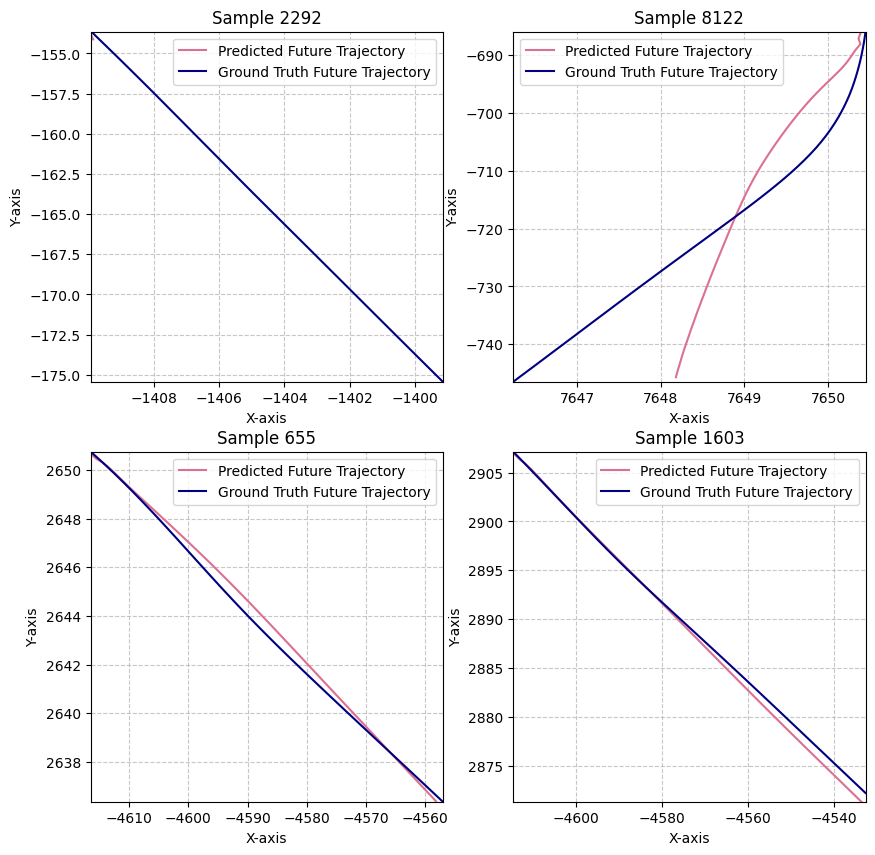

In [92]:
model = get_model()
if not isinstance(model, SceneContextModel):
    # LSTM can handle the timeseries data directly
    # TrajectoryDataset expects numpy arrays
    collate_func = lambda x: Batch.from_data_list(x)
    train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
else:
    train_x: np.ndarray = train_data[..., :50, :]
    train_y: np.ndarray = train_data[:, 0, 50:, :2]
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

visualize_predictions(model, train_dataset)